# Deep Deterministic Policy Gradients

In [0]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import gym
import numpy as np

In [0]:
# check and use GPU if available if not use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### LunarLander

LunarLander is an OpenAI gym environment (env). The agent receives a reward for navigating to the landing pad and turning off the engine, a large reward for a safe landing, a large negative reward for an unsafe landing, and a small negative reward for using the engines. There are discrete and continuous versions of LunarLander. In the continuous case, the agent uses two engines along a continuous range of values from -1 to 1.

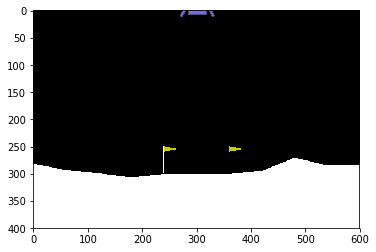

In [0]:
env = gym.make('LunarLanderContinuous-v2')
env.reset()

prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

for i in range(200):
    env.render()
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    if done:
        env.reset()
        
env.close()

### Experience Replay Buffer

In [0]:
# replay buffer from and some code based on https://github.com/sfujim/TD3

# create replay buffer of tuples of (state, next_state, action, reward, done)
class ReplayBuffer():
    def __init__(self, max_size=1e6):
        self.storage = []
        self.max_size = max_size
        self.ptr = 0

    def add(self, data):
        if len(self.storage) == self.max_size:
            self.storage[int(self.ptr)] = data
            self.ptr = (self.ptr + 1) % self.max_size
        else:
            self.storage.append(data)

    def sample(self, batch_size):
        ind = np.random.randint(0, len(self.storage), size=batch_size)
        x, y, u, r, d = [], [], [], [], []

        for i in ind: 
            X, Y, U, R, D = self.storage[i]
            x.append(np.array(X, copy=False))
            y.append(np.array(Y, copy=False))
            u.append(np.array(U, copy=False))
            r.append(np.array(R, copy=False))
            d.append(np.array(D, copy=False))

        return np.array(x), np.array(y), np.array(u), np.array(r).reshape(-1,1), np.array(d).reshape(-1,1)

### DDPG Architecture

The deterministic policy gradients are used to train the actor network. DDPG is off-policy and combines some methods used for Deep Q Networks (DQN) like target network updating and an experience replay buffer. Unlike DQN, DDPG can be used in the continuous action space. In this example, we train a DDPG network on continuous Lunar Lander.

In [0]:
class ActorNet(nn.Module):
    def __init__(self, state_size, action_size, hidden_size, action_max):
        super(ActorNet, self).__init__()
        self.dense_layer_1 = nn.Linear(state_size, hidden_size)
        self.dense_layer_2 = nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, action_size)
        self.action_max = action_max
    
    def forward(self, x):
        x = torch.clamp(x,-1.1,1.1)
        x = F.relu(self.dense_layer_1(x))
        x = F.relu(self.dense_layer_2(x))
        return torch.tanh(self.output(x)) * self.action_max
    
class CriticNet(nn.Module):
    def __init__(self, state_size, action_size, hidden_size):
        super(CriticNet, self).__init__()
        self.dense_layer_1 = nn.Linear(state_size+action_size, hidden_size)
        self.dense_layer_2 = nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, 1)
    
    def forward(self, x, a):
        x = torch.clamp(x,-1.1,1.1)
        x = F.relu(self.dense_layer_1(torch.cat((x,a),dim=1)))
        x = F.relu(self.dense_layer_2(x))
        return self.output(x)

### DDPGAgent Class

In [0]:
class DDPGAgent():
    def __init__(self, state_size, action_size, hidden_size, actor_lr, critic_lr, discount,
                 min_action, max_action, exploration_noise):
        self.action_size = action_size
        self.actor = ActorNet(state_size, action_size, hidden_size, max_action).to(device)
        self.actor_target = ActorNet(state_size, action_size, hidden_size, max_action).to(device)
        self.critic = CriticNet(state_size, action_size, hidden_size).to(device)
        self.critic_target = CriticNet(state_size, action_size, hidden_size).to(device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.critic_target.load_state_dict(self.critic.state_dict())
        
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_lr)
        self.discount = discount
        self.min_action = min_action
        self.max_action = max_action
        self.exploration_noise = exploration_noise
        
    def select_action(self, state):
        #get action probs then randomly sample from the probabilities
        with torch.no_grad():
            input_state = torch.FloatTensor(state).to(device)
            action = self.actor(input_state)
            #detach and turn to numpy to use with np.random.choice()
            action = action.detach().cpu().numpy()
            #in DDPG add noise for exploration
            action = (action + np.random.normal(0., self.exploration_noise, 
                       size=self.action_size)).clip(self.min_action, self.max_action)   
        return action

    
    def train(self, replay_buffer, batch_size):
        # sample a batch from the replay buffer
        x0, x1, a, r, d = replay_buffer.sample(batch_size)
        # turn batches into tensors and use GPU if available
        state_batch = torch.FloatTensor(x0).to(device)
        next_state_batch = torch.FloatTensor(x1).to(device)
        action_batch = torch.FloatTensor(a).to(device)
        reward_batch = torch.FloatTensor(r).to(device)
        flipped_done_batch = torch.FloatTensor(d).to(device) #already flipped done when adding to replay buffer

        # get target net target values
        with torch.no_grad():
            target_action = self.actor_target(next_state_batch).view(batch_size,-1)
            target_v = reward_batch + flipped_done_batch*self.discount*self.critic_target(next_state_batch, 
                                                                           target_action).view(batch_size,-1)
        # get train net values for updating the critic network    
        critic_v = self.critic(state_batch, action_batch).view(batch_size,-1)
        
        # train critic
        critic_loss = F.smooth_l1_loss(critic_v, target_v)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step() 
        
        # train actor
        train_action = self.actor(state_batch)
        actor_loss = -torch.mean(self.critic(state_batch,train_action))
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step() 
        
        return actor_loss.detach().cpu().numpy(), critic_loss.detach().cpu().numpy()
        
        
    def update_target_network_soft(self, num_iter, update_every, update_tau=0.001):
        # soft target network update: update target networks with mixture of train and target
        if num_iter % update_every == 0:
            for target_var, var in zip(self.critic_target.parameters(), self.critic.parameters()):
                target_var.data.copy_((1.-update_tau) * target_var.data + (update_tau) * var.data)
            for target_var, var in zip(self.actor_target.parameters(), self.actor.parameters()):
                target_var.data.copy_((1.-update_tau) * target_var.data + (update_tau) * var.data)

In [0]:
# Initialize env and set up hyperparameters
env = gym.make('LunarLanderContinuous-v2')
action_size = env.action_space.shape[0]
state_size = env.observation_space.shape[0]
min_action = env.action_space.low[0]
max_action = env.action_space.high[0]

# set seed
seed = 31
env.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
# create replay buffer
replay_size = 50000 # size of replay buffer
replay_buffer = ReplayBuffer(max_size=replay_size)    

# target update hyperparameters
start_training_after = 10001 # start training NN after this many timesteps
update_target_every = 1 # update target network every this steps
tau = 0.001

episodes = 5000    
discount = 0.99
batch_size = 32
exploration_noise = 0.1
hidden_size = 64
actor_lr = 0.0005
critic_lr = 0.0005
reward_scale = 0.01

# create DDPG Agent
agent = DDPGAgent(state_size=state_size, action_size=action_size, hidden_size=hidden_size, 
                  actor_lr=actor_lr, critic_lr=critic_lr, discount=discount, min_action=min_action,
                  max_action=max_action, exploration_noise=exploration_noise)

### The RL Training Loop

In the loop, we iterate through our episodes and then the timesteps within the episodes. We stop training the agent based on some stopping condition like a max episode value, a max timestep value, or if the agent's performance reaches a certain level.

In each episode and at each timestep the agent selects an action, calls env.step(), and stores the sample in the replay buffer. The agent will also train the training neural network and periodically update the target network. When an episode is done the env is reset.

In [0]:
stats_rewards_list = [] # store stats for plotting in this
stats_every = 10 # print stats every this many episodes
total_reward = 0
timesteps = 0
episode_length = 0
stats_actor_loss, stats_critic_loss = [], []

for ep in range(episodes):
    state = env.reset()

    # stopping condition for training if agent reaches the amount of reward
    if len(stats_rewards_list) > stats_every and np.mean(stats_rewards_list[-stats_every:],axis=0)[1] > 190:
        print("Stopping at episode {} with average rewards of {} in last {} episodes".
            format(ep, np.mean(stats_rewards_list[-stats_every:],axis=0)[1], stats_every))
        break  

    # train in each episode until episode is done
    while True:
        timesteps += 1
        #env.render()
        # select an action from the agent's policy
        action = agent.select_action(state)
        
        # enter action into the env
        next_state, reward, done, _ = env.step(action)
        total_reward += reward
        episode_length += 1
        # end episode early
        if total_reward < -250:
            done = 1
        
        # add experience to replay buffer
        replay_buffer.add((state, next_state, action, reward*reward_scale, 1-float(done)))
        
        # train the agent
        if timesteps >= start_training_after:
            actor_loss, critic_loss = agent.train(replay_buffer, batch_size)
            stats_actor_loss.append(actor_loss) 
            stats_critic_loss.append(critic_loss) 
            agent.update_target_network_soft(timesteps, update_target_every)
            
        if done:
            stats_rewards_list.append((ep, total_reward, episode_length))
            total_reward = 0
            episode_length = 0  
            if timesteps >= start_training_after and ep % stats_every == 0:
                print('Episode: {}'.format(ep),
                    'Timestep: {}'.format(timesteps),
                    'Total reward: {:.1f}'.format(np.mean(stats_rewards_list[-stats_every:],axis=0)[1]),
                    'Episode length: {:.1f}'.format(np.mean(stats_rewards_list[-stats_every:],axis=0)[2]),
                    'Actor Loss: {:.4f}'.format(np.mean(stats_actor_loss)), 
                    'Critic Loss: {:.4f}'.format(np.mean(stats_critic_loss)))
                stats_actor_loss, stats_critic_loss = [], []
            break
        
        state = next_state

Episode: 90 Timestep: 10400 Total reward: -218.1 Episode length: 119.7 Actor Loss: -0.0580 Critic Loss: 0.0047
Episode: 100 Timestep: 11944 Total reward: -227.6 Episode length: 154.4 Actor Loss: -0.0430 Critic Loss: 0.0032
Episode: 110 Timestep: 13268 Total reward: -250.8 Episode length: 132.4 Actor Loss: -0.0281 Critic Loss: 0.0023
Episode: 120 Timestep: 14667 Total reward: -259.8 Episode length: 139.9 Actor Loss: -0.0147 Critic Loss: 0.0019
Episode: 130 Timestep: 16088 Total reward: -244.7 Episode length: 142.1 Actor Loss: -0.0034 Critic Loss: 0.0014
Episode: 140 Timestep: 19174 Total reward: -270.8 Episode length: 308.6 Actor Loss: 0.0057 Critic Loss: 0.0012
Episode: 150 Timestep: 24111 Total reward: -176.5 Episode length: 493.7 Actor Loss: 0.0046 Critic Loss: 0.0010
Episode: 160 Timestep: 28013 Total reward: -167.0 Episode length: 390.2 Actor Loss: -0.0151 Critic Loss: 0.0009
Episode: 170 Timestep: 31147 Total reward: -139.5 Episode length: 313.4 Actor Loss: -0.0329 Critic Loss: 0.

Text(0, 0.5, 'Episode Reward')

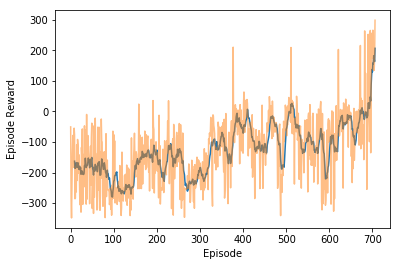

In [0]:
# plot stats
def get_running_stat(stat, stat_len):
    cum_sum = np.cumsum(np.insert(stat, 0, 0)) 
    return (cum_sum[stat_len:] - cum_sum[:-stat_len]) / stat_len

episode, r, l = np.array(stats_rewards_list).T
cum_r = get_running_stat(r, 10)
cum_l = get_running_stat(l, 10)

# plot rewards
plt.plot(episode[-len(cum_r):], cum_r)
plt.plot(episode, r, alpha=0.5)
plt.xlabel('Episode')
plt.ylabel('Episode Reward')

Text(0, 0.5, 'Episode Length')

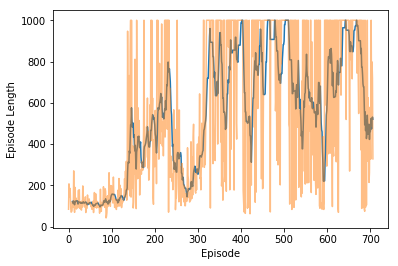

In [0]:
# plot episode lengths
plt.plot(episode[-len(cum_l):], cum_l)
plt.plot(episode, l, alpha=0.5)
plt.xlabel('Episode')
plt.ylabel('Episode Length')